In [1]:
from PINN import PINN
from dataloader import DataloaderEuropean1D
import torch

import logging
from datetime import datetime

N_EPOCH = 4_000
LEARNING_RATE = 1e-5
HIDDEN_LAYER = 6
HIDDEN_WIDTH = 256
N_sample = 8000
PHYSICS_PENALTY = 52
BVP1_PENALTY = 8
DEVICE = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
torch.set_default_device(DEVICE)

K = 40
r = 0.05
sigma = 0.2
T = 1
S_range = [0, 160]
t_range = [0, T]

euro_call_data = DataloaderEuropean1D(t_range, S_range, K, r, sigma)

model = PINN(2, 1, HIDDEN_WIDTH, HIDDEN_LAYER).to(DEVICE)


In [2]:
physics_lr = PHYSICS_PENALTY
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

loss_history={
    "total_loss":[],"loss_ivp_bvp":[],"loss_BS":[],\
    "loss_bvp1":[],"loss_bvp2":[],"loss_ivp":[],
}


In [3]:
import torch
import torch.autograd as tgrad
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

In [5]:
r_ivp,r_bvp1,r_bvp2 = 1,1,1
for i in range(N_EPOCH):
    model.train();
    # Get IVP data
    ivp_x_tensor,ivp_y_tensor = euro_call_data.get_expiry_time_tensor(N_sample,r_ivp)
    print(ivp_y_tensor)
    ivp_x_tensor = ivp_x_tensor.to(DEVICE)
    ivp_y_tensor = ivp_y_tensor.to(DEVICE)
    # ivp_x_tensor = euro_call_data.normalize(ivp_x_tensor)
    ivp_y_pred = model(ivp_x_tensor)
    mse_ivp = nn.MSELoss()(ivp_y_tensor, ivp_y_pred)

    # Get BVP data
    bvp_x1_tensor,bvp_y1_tensor,bvp_x2_tensor,bvp_y2_tensor = euro_call_data.get_boundary_data_tensor(N_sample,r_bvp1,r_bvp2)
    bvp_x1_tensor,bvp_y1_tensor = bvp_x1_tensor.to(DEVICE),bvp_y1_tensor.to(DEVICE)
    bvp_x2_tensor,bvp_y2_tensor = bvp_x2_tensor.to(DEVICE),bvp_y2_tensor.to(DEVICE)
    # bvp_x1_tensor = euro_call_data.normalize(bvp_x1_tensor)
    bvp_y1_pred = model(bvp_x1_tensor)
    mse_bvp1 = nn.MSELoss()(bvp_y1_tensor, bvp_y1_pred)
    # bvp_x2_tensor = euro_call_data.normalize(bvp_x2_tensor)
    bvp_y2_pred = model(bvp_x2_tensor)
    mse_bvp2 = nn.MSELoss()(bvp_y2_tensor, bvp_y2_pred)

    # Aggregate the "data loss"
    loss1 = mse_ivp + BVP1_PENALTY*mse_bvp1 + mse_bvp2

    # Compute the "Black-Scholes loss"
    X1,y1 = euro_call_data.get_pde_data(N_sample)
    X1 = torch.from_numpy(X1).float().requires_grad_().to(DEVICE)
    y1 = torch.from_numpy(y1).float().to(DEVICE)
    y1_hat = model(X1)
    grads = torch.autograd.grad(y1_hat, X1, grad_outputs=torch.ones(y1_hat.shape).to(DEVICE), retain_graph=True, create_graph=True, only_inputs=True)[0]
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = torch.autograd.grad(dVdS, X1, grad_outputs=torch.ones(dVdS.shape).to(DEVICE), create_graph=True, only_inputs=True)[0]
    d2VdS2 = grads2nd[:, 1].view(-1, 1)
    S1 = X1[:, 1].view(-1, 1)
    bs_pde = dVdt + (0.5 * ((sigma * S1) ** 2) * d2VdS2) + (r * S1 * dVdS) - (r * y1_hat)
    loss2 = physics_lr * nn.MSELoss()(bs_pde, torch.zeros_like(bs_pde))

    # Backpropagate joint loss
    loss = loss1 + loss2
    loss_history["total_loss"].append(loss.item())
    loss_history["loss_ivp_bvp"].append(loss1.item())
    loss_history["loss_BS"].append(loss2.item())
    loss_history["loss_ivp"].append(mse_ivp.item())
    loss_history["loss_bvp1"].append(mse_bvp1.item())
    loss_history["loss_bvp2"].append(mse_bvp2.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Plot the result as training progresses
    if (i + 1) % 500 == 0:
        print(f"Epoch {i+1}, Loss: {loss.item():.4f}")
    

tensor([[  0.0000],
        [119.0804],
        [116.4002],
        ...,
        [ 23.0849],
        [ 75.9633],
        [  0.0000]])
tensor([[77.8322],
        [ 0.0000],
        [27.4894],
        ...,
        [97.3798],
        [ 0.0000],
        [ 0.0000]])
tensor([[ 3.3436],
        [72.9676],
        [28.6213],
        ...,
        [ 0.0000],
        [ 0.0000],
        [20.2421]])
tensor([[43.6016],
        [27.9903],
        [ 0.0000],
        ...,
        [87.1777],
        [67.3406],
        [ 0.0000]])
tensor([[ 0.0000],
        [65.1566],
        [ 8.2357],
        ...,
        [45.4883],
        [26.8272],
        [ 0.0000]])
tensor([[61.1765],
        [ 0.0000],
        [84.4992],
        ...,
        [32.3511],
        [15.5492],
        [94.2865]])
tensor([[  5.1384],
        [ 70.4526],
        [  0.0000],
        ...,
        [  0.0000],
        [ 51.6686],
        [116.6734]])
tensor([[116.7891],
        [110.7155],
        [ 78.0998],
        ...,
        [  0.0000],

KeyboardInterrupt: 

In [ ]:
import pandas as pd

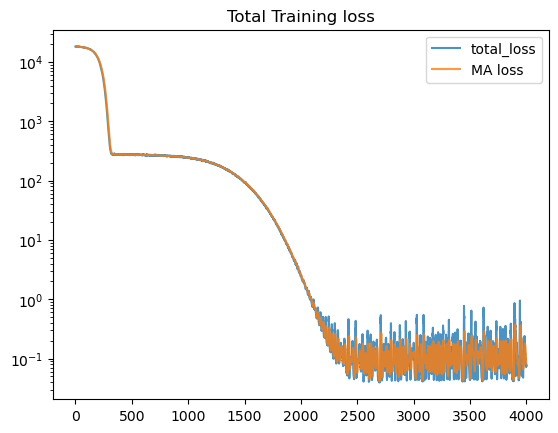

In [ ]:
loss_df = pd.DataFrame.from_dict(loss_history)
ax = loss_df[["total_loss"]].plot(logy=True,alpha=0.8)
loss_df[["total_loss"]].rename(columns={"total_loss":"MA loss"}).rolling(10).mean().plot(logy=True,alpha=0.8, label="MA", ax = ax)
plt.title("Total Training loss")
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'sup_title'

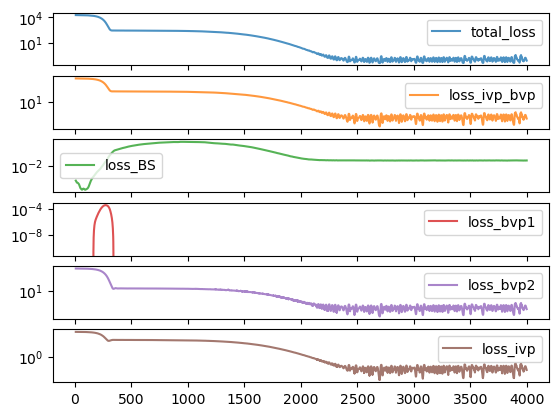

In [ ]:
loss_df.rolling(10).mean().plot(logy=True,alpha=0.8, subplots = True)
plt.sup_title("Training Curve for Moving Average of losses")
plt.show()